In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.3 MB/s eta 0:00:00


In [4]:
import os
import cv2
import csv
import numpy as np
from typing import Any, Dict, List, Optional, Tuple

In [ ]:
import cv2
from ultralytics import YOLO

def implement_detection(model_path, video_path):
    model = YOLO(model_path)
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video file.")
        return

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    output_path = 'output_car_detection1.mp4'
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    # Get the class ID for 'car' from your model's class names
    car_class_id = list(model.names.values()).index('Car')

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        results = model(frame)

        for box in results[0].boxes:
            cls = int(box.cls[0])
            if cls == car_class_id:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
                conf = box.conf[0].cpu().numpy()

                label = f"{model.names[cls]}: {conf:.2f}"
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        out.write(frame)

    cap.release()
    out.release()
    print(f"Video processing complete. Output saved to: {output_path}")


model_file = '/content/best (6).pt'

video_file = '/content/CarSev 3.mp4'

implement_detection(model_file, video_file)


0: 224x480 2 Cars, 191.4ms
Speed: 2.7ms preprocess, 191.4ms inference, 10.0ms postprocess per image at shape (1, 3, 224, 480)

0: 224x480 2 Cars, 182.0ms
Speed: 2.0ms preprocess, 182.0ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 480)

0: 224x480 3 Cars, 182.7ms
Speed: 2.2ms preprocess, 182.7ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 480)

0: 224x480 2 Cars, 186.2ms
Speed: 2.5ms preprocess, 186.2ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 480)

0: 224x480 2 Cars, 199.9ms
Speed: 2.4ms preprocess, 199.9ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 480)

0: 224x480 2 Cars, 190.2ms
Speed: 2.2ms preprocess, 190.2ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 480)

0: 224x480 2 Cars, 181.9ms
Speed: 1.9ms preprocess, 181.9ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 480)

0: 224x480 2 Cars, 181.2ms
Speed: 1.9ms preprocess, 181.2ms inference, 0.8ms postprocess per image at shape (1, 3, 2

In [ ]:
import cv2
import numpy as np
import os

def get_centroid(bbox):
    x1, y1, x2, y2 = bbox
    return (int((x1 + x2) / 2), int((y1 + y2) / 2))


def extract_boxes_from_frame(frame, color_lower, color_upper):
    """Detect bounding boxes by color (from drawn rectangles)."""
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, color_lower, color_upper)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 40 and h > 40:  # filter noise
            boxes.append((x, y, x + w, y + h))
    return boxes


def mask_car(frame, bbox):
    """Keep only the car region and black out the rest."""
    x1, y1, x2, y2 = bbox
    masked = np.zeros_like(frame)
    masked[y1:y2, x1:x2] = frame[y1:y2, x1:x2]
    return masked


def is_car_near(bbox, frame_height, frame_width):
    """
    Adaptive near-car detection based on frame size.
    """
    x1, y1, x2, y2 = bbox
    bbox_height = y2 - y1
    bbox_area = (x2 - x1) * bbox_height
    bottom_dist = frame_height - y2

    # thresholds relative to frame dimensions
    area_threshold = 0.02 * (frame_height * frame_width)  # ≥ 2% of frame area
    height_threshold = 0.15 * frame_height               # ≥ 15% of frame height
    max_bottom_dist = 0.25 * frame_height                # bottom 25% of frame

    print(f"[DEBUG] area={bbox_area}, height={bbox_height}, bottom_dist={bottom_dist}, "
          f"req_area={area_threshold:.1f}, req_height={height_threshold:.1f}, req_bottom={max_bottom_dist:.1f}")

    return (bbox_area >= area_threshold) and \
           (bbox_height >= height_threshold) and \
           (bottom_dist <= max_bottom_dist)


def process_video(video_path, out_dir, move_thresh=5, area_thresh=12000):
    """
    Process video; select moving cars close to camera.
    move_thresh: minimum movement in pixels to consider car moving
    area_thresh: minimum bounding box area to consider for processing
    """
    os.makedirs(out_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    frame_idx = 0

    # HSV color bounds (green box example)
    color_lower = np.array([50, 100, 100])
    color_upper = np.array([70, 255, 255])

    prev_centroids = {}
    track_id = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_height, frame_width = frame.shape[:2]
        boxes = extract_boxes_from_frame(frame, color_lower, color_upper)
        current_centroids = {}

        moving_candidates = []
        for bbox in boxes:
            cx, cy = get_centroid(bbox)
            area = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])

            if area < area_thresh:
                continue

            # tracking: assign ID
            found_id = None
            for tid, pc in prev_centroids.items():
                if np.linalg.norm(np.array(pc) - np.array((cx, cy))) < 50:
                    found_id = tid
                    break
            if found_id is None:
                track_id += 1
                found_id = track_id

            current_centroids[found_id] = (cx, cy)

            # compute movement distance
            if found_id in prev_centroids:
                dist = np.linalg.norm(np.array(prev_centroids[found_id]) - np.array((cx, cy)))
                if dist > move_thresh:
                    moving_candidates.append((bbox, area, found_id))

        # === Selection Logic ===
        selected = None
        if moving_candidates:
            selected = max(moving_candidates, key=lambda x: x[1])  # largest area moving car
        elif boxes:
            filtered_boxes = [(b, (b[2] - b[0]) * (b[3] - b[1]), -1) for b in boxes if
                              (b[2] - b[0]) * (b[3] - b[1]) >= area_thresh]
            if filtered_boxes:
                selected = max(filtered_boxes, key=lambda x: x[1])

        if selected:
            bbox, area, cid = selected
            if is_car_near(bbox, frame_height, frame_width):
                masked = mask_car(frame, bbox)
                save_path = os.path.join(out_dir, f"frame{frame_idx:05d}_car{cid:02d}.jpg")
                cv2.imwrite(save_path, masked)
                print(f"[INFO] Saved {save_path} (area={area}, id={cid})")
            else:
                print(f"[INFO] Skipped masking car id={cid}: not near enough")

        prev_centroids = current_centroids
        frame_idx += 1

    cap.release()
    print(f"[INFO] Masked car regions saved in {out_dir}")



process_video("/content/output_car_detection1.mp4", "/content/masked_cars00")



[DEBUG] area=43512, height=222, bottom_dist=340, req_area=14229.8, req_height=84.3, req_bottom=140.5
[INFO] Skipped masking car id=-1: not near enough
[DEBUG] area=43164, height=218, bottom_dist=344, req_area=14229.8, req_height=84.3, req_bottom=140.5
[INFO] Skipped masking car id=-1: not near enough
[DEBUG] area=42292, height=218, bottom_dist=344, req_area=14229.8, req_height=84.3, req_bottom=140.5
[INFO] Skipped masking car id=-1: not near enough
[DEBUG] area=41856, height=218, bottom_dist=342, req_area=14229.8, req_height=84.3, req_bottom=140.5
[INFO] Skipped masking car id=-1: not near enough
[DEBUG] area=41856, height=218, bottom_dist=342, req_area=14229.8, req_height=84.3, req_bottom=140.5
[INFO] Skipped masking car id=-1: not near enough
[DEBUG] area=42240, height=220, bottom_dist=342, req_area=14229.8, req_height=84.3, req_bottom=140.5
[INFO] Skipped masking car id=-1: not near enough
[DEBUG] area=43392, height=226, bottom_dist=336, req_area=14229.8, req_height=84.3, req_bottom

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Found 37 images.


  0%|          | 0/37 [00:00<?, ?it/s]


0: 288x640 (no detections), 859.0ms
Speed: 3.1ms preprocess, 859.0ms inference, 0.5ms postprocess per image at shape (1, 3, 288, 640)


  3%|▎         | 1/37 [00:01<00:43,  1.22s/it]


0: 288x640 (no detections), 750.2ms
Speed: 3.1ms preprocess, 750.2ms inference, 0.5ms postprocess per image at shape (1, 3, 288, 640)


  5%|▌         | 2/37 [00:01<00:33,  1.05it/s]


0: 288x640 (no detections), 746.9ms
Speed: 3.2ms preprocess, 746.9ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 640)


  8%|▊         | 3/37 [00:02<00:29,  1.16it/s]


0: 288x640 (no detections), 745.8ms
Speed: 3.0ms preprocess, 745.8ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


 11%|█         | 4/37 [00:03<00:27,  1.22it/s]


0: 288x640 (no detections), 738.1ms
Speed: 3.0ms preprocess, 738.1ms inference, 0.5ms postprocess per image at shape (1, 3, 288, 640)


 14%|█▎        | 5/37 [00:04<00:25,  1.25it/s]


0: 288x640 (no detections), 751.8ms
Speed: 3.0ms preprocess, 751.8ms inference, 0.5ms postprocess per image at shape (1, 3, 288, 640)


 16%|█▌        | 6/37 [00:05<00:24,  1.27it/s]


0: 288x640 (no detections), 745.5ms
Speed: 3.0ms preprocess, 745.5ms inference, 0.5ms postprocess per image at shape (1, 3, 288, 640)


 19%|█▉        | 7/37 [00:05<00:23,  1.29it/s]


0: 288x640 (no detections), 746.0ms
Speed: 3.4ms preprocess, 746.0ms inference, 0.5ms postprocess per image at shape (1, 3, 288, 640)


 22%|██▏       | 8/37 [00:06<00:22,  1.30it/s]


0: 288x640 (no detections), 739.5ms
Speed: 2.6ms preprocess, 739.5ms inference, 0.5ms postprocess per image at shape (1, 3, 288, 640)


 24%|██▍       | 9/37 [00:07<00:21,  1.31it/s]


0: 288x640 (no detections), 757.3ms
Speed: 3.2ms preprocess, 757.3ms inference, 0.5ms postprocess per image at shape (1, 3, 288, 640)


 27%|██▋       | 10/37 [00:08<00:20,  1.30it/s]


0: 288x640 (no detections), 821.2ms
Speed: 3.0ms preprocess, 821.2ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 640)


 30%|██▉       | 11/37 [00:08<00:20,  1.27it/s]


0: 288x640 (no detections), 1163.4ms
Speed: 3.2ms preprocess, 1163.4ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 640)


 32%|███▏      | 12/37 [00:10<00:22,  1.10it/s]


0: 288x640 (no detections), 1159.0ms
Speed: 3.1ms preprocess, 1159.0ms inference, 0.5ms postprocess per image at shape (1, 3, 288, 640)


 35%|███▌      | 13/37 [00:11<00:23,  1.01it/s]


0: 288x640 1 License_Plate, 778.2ms
Speed: 3.2ms preprocess, 778.2ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 640)


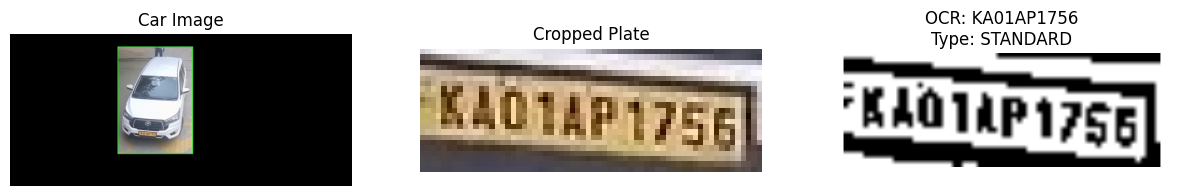

 38%|███▊      | 14/37 [00:21<01:30,  3.92s/it]


0: 288x640 (no detections), 1173.0ms
Speed: 3.2ms preprocess, 1173.0ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 640)


 41%|████      | 15/37 [00:23<01:08,  3.10s/it]


0: 288x640 (no detections), 943.4ms
Speed: 3.1ms preprocess, 943.4ms inference, 0.5ms postprocess per image at shape (1, 3, 288, 640)


 43%|████▎     | 16/37 [00:24<00:51,  2.46s/it]


0: 288x640 1 License_Plate, 753.5ms
Speed: 4.1ms preprocess, 753.5ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 640)


 46%|████▌     | 17/37 [00:35<01:43,  5.17s/it]


0: 288x640 (no detections), 951.2ms
Speed: 3.5ms preprocess, 951.2ms inference, 0.5ms postprocess per image at shape (1, 3, 288, 640)


 49%|████▊     | 18/37 [00:36<01:14,  3.91s/it]


0: 288x640 1 License_Plate, 754.2ms
Speed: 3.4ms preprocess, 754.2ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 640)


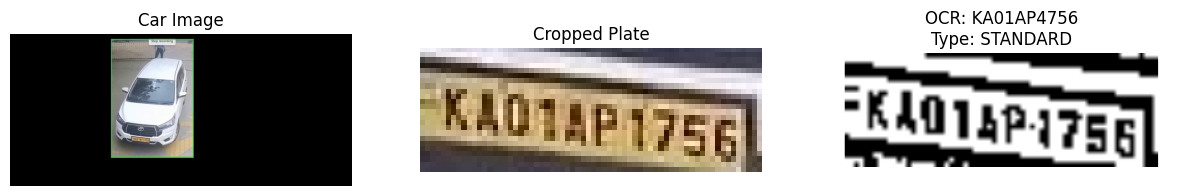

 51%|█████▏    | 19/37 [00:47<01:46,  5.93s/it]


0: 288x640 1 License_Plate, 1161.1ms
Speed: 3.2ms preprocess, 1161.1ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 54%|█████▍    | 20/37 [00:58<02:10,  7.68s/it]


0: 288x640 1 License_Plate, 1193.4ms
Speed: 3.1ms preprocess, 1193.4ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)


 57%|█████▋    | 21/37 [01:10<02:23,  8.96s/it]


0: 288x640 1 License_Plate, 1068.9ms
Speed: 3.1ms preprocess, 1068.9ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)


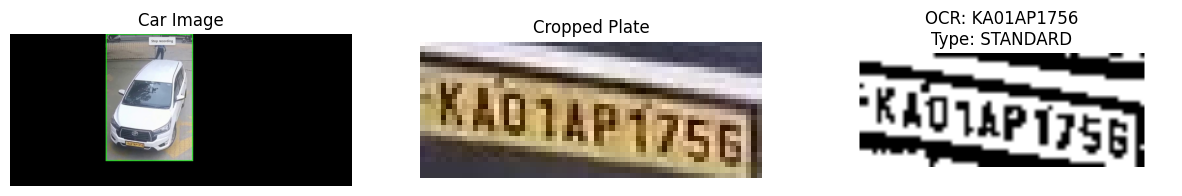

 59%|█████▉    | 22/37 [01:22<02:24,  9.64s/it]


0: 288x640 (no detections), 743.9ms
Speed: 3.1ms preprocess, 743.9ms inference, 0.5ms postprocess per image at shape (1, 3, 288, 640)


 62%|██████▏   | 23/37 [01:22<01:37,  6.98s/it]


0: 288x640 (no detections), 715.7ms
Speed: 3.0ms preprocess, 715.7ms inference, 0.5ms postprocess per image at shape (1, 3, 288, 640)


 65%|██████▍   | 24/37 [01:23<01:06,  5.10s/it]


0: 288x640 1 License_Plate, 1140.1ms
Speed: 3.8ms preprocess, 1140.1ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)


 68%|██████▊   | 25/37 [01:35<01:26,  7.21s/it]


0: 288x640 (no detections), 909.5ms
Speed: 3.8ms preprocess, 909.5ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 640)


 70%|███████   | 26/37 [01:36<00:58,  5.32s/it]


0: 288x640 1 License_Plate, 1155.1ms
Speed: 8.7ms preprocess, 1155.1ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 73%|███████▎  | 27/37 [01:46<01:08,  6.80s/it]


0: 288x640 1 License_Plate, 727.5ms
Speed: 3.2ms preprocess, 727.5ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 640)


 76%|███████▌  | 28/37 [01:58<01:13,  8.20s/it]


0: 288x640 1 License_Plate, 732.6ms
Speed: 2.2ms preprocess, 732.6ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 640)


 78%|███████▊  | 29/37 [02:09<01:13,  9.18s/it]


0: 288x640 1 License_Plate, 743.4ms
Speed: 3.2ms preprocess, 743.4ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 640)


 81%|████████  | 30/37 [02:21<01:09,  9.87s/it]


0: 288x640 1 License_Plate, 730.6ms
Speed: 3.3ms preprocess, 730.6ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 640)


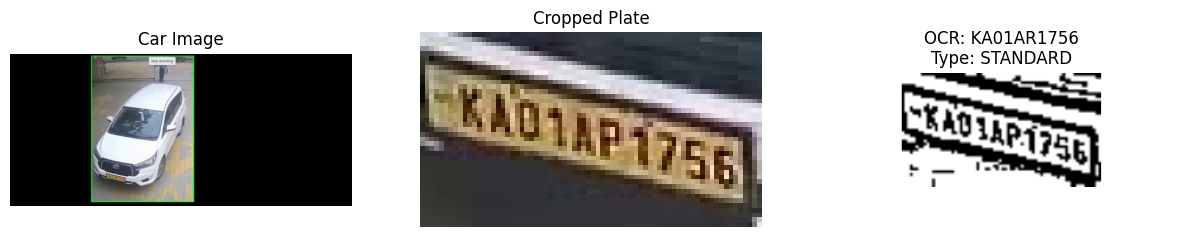

 84%|████████▍ | 31/37 [02:33<01:03, 10.58s/it]


0: 288x640 1 License_Plate, 753.9ms
Speed: 3.3ms preprocess, 753.9ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 640)


 86%|████████▋ | 32/37 [02:45<00:55, 11.04s/it]


0: 288x640 1 License_Plate, 716.2ms
Speed: 3.1ms preprocess, 716.2ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 640)


 89%|████████▉ | 33/37 [02:57<00:45, 11.34s/it]


0: 288x640 1 License_Plate, 736.8ms
Speed: 3.2ms preprocess, 736.8ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 640)


 92%|█████████▏| 34/37 [03:08<00:33, 11.24s/it]


0: 288x640 1 License_Plate, 727.8ms
Speed: 3.2ms preprocess, 727.8ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 640)


 95%|█████████▍| 35/37 [03:22<00:23, 11.96s/it]


0: 288x640 1 License_Plate, 719.7ms
Speed: 3.1ms preprocess, 719.7ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 97%|█████████▋| 36/37 [03:34<00:11, 12.00s/it]


0: 288x640 1 License_Plate, 747.7ms
Speed: 3.2ms preprocess, 747.7ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 640)


100%|██████████| 37/37 [03:44<00:00,  6.07s/it]


In [17]:
import os
import re
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from ultralytics import YOLO
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

# === Paths ===
input_folder = '/content/masked_cars00'

# === Load Models ===
model_yolo = YOLO('/content/license-plate-finetune-v1l.pt')
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
trocr_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed")

# === Regex & State Codes (backward check) ===
pattern_standard = r'^[A-Z]{2}[0-9]{1,2}[A-Z]{2,3}[0-9]{4}$'
pattern_bh = r'^[A-Z]{2}[0-9]{2}BH[0-9]{4}[A-Z]{2}$'
valid_state_codes = {
    "AP","AR","AS","BR","CH","CT","DN","DD","DL","GA","GJ","HR","HP",
    "JH","JK","KA","KL","LD","MH","ML","MN","MP","MZ","NL","OD","PB",
    "PY","RJ","SK","TN","TR","TS","UK","UP","WB"
}

# === Helper Functions ===
def remove_inr_sticker(plate_img, side='left', ratio=0.10):
    h, w = plate_img.shape[:2]
    offset = int(w * ratio)
    return plate_img[:, offset:] if side == 'left' else plate_img[:, :-offset]

def preprocess_plate_v2(plate_img):
    gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
    norm = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)
    binary = cv2.adaptiveThreshold(norm, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 11, 2)
    target_w, target_h = 300, 100
    h, w = binary.shape
    scale = min(target_w / w, target_h / h)
    resized = cv2.resize(binary, (int(w * scale), int(h * scale)))
    top = (target_h - resized.shape[0]) // 2
    bottom = target_h - resized.shape[0] - top
    left = (target_w - resized.shape[1]) // 2
    right = target_w - resized.shape[1] - left
    padded = cv2.copyMakeBorder(resized, top, bottom, left, right,
                                cv2.BORDER_CONSTANT, value=[255])
    return padded

def trocr_predict(img):
    pil_img = Image.fromarray(img).convert("RGB")
    inputs = processor(pil_img, return_tensors="pt")
    outputs = trocr_model.generate(**inputs)
    return re.sub(r'[^A-Z0-9]', '', processor.batch_decode(outputs, skip_special_tokens=True)[0].upper())

def correct_plate_format(text):
    text = text.strip().upper()
    corrected = list(text)
    letter_positions = [0, 1, 4, 5]

    for i, ch in enumerate(corrected):
        if ch == '0' and i in letter_positions:
            corrected[i] = 'Q'
    cleaned = ''.join(corrected)

    state_code = cleaned[:2]
    if state_code not in valid_state_codes:
        return cleaned, "INVALID_STATE"
    if re.match(pattern_bh, cleaned):
        return cleaned, "BH"
    if re.match(pattern_standard, cleaned):
        return cleaned, "STANDARD"
    return cleaned, "UNMATCHED"

# === Collect Image Files ===
all_images = sorted([
    f for f in os.listdir(input_folder)
    if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.webp'))
])

print(f"Found {len(all_images)} images.")

# === Main Loop ===
for img_file in tqdm(all_images):  # adjust number of images here
    img_path = os.path.join(input_folder, img_file)
    image = cv2.imread(img_path)
    if image is None:
        continue

    results = model_yolo(image)
    boxes = results[0].boxes.data.cpu().numpy()

    for box in boxes:
        class_id = int(box[5])
        if class_id == 0:  # number plate
            x1, y1, x2, y2 = map(int, box[:4])
            plate_crop = image[y1:y2, x1:x2]
            plate_crop_no_inr = remove_inr_sticker(plate_crop)

            # OCR
            trocr_raw = trocr_predict(plate_crop_no_inr)
            preprocessed = preprocess_plate_v2(plate_crop_no_inr)
            trocr_pre = trocr_predict(preprocessed)

            # Correction
            corrected_text, plate_type = correct_plate_format(trocr_pre)

            # === Only show if valid regex ===
            if plate_type in ["STANDARD", "BH"]:
                fig, axs = plt.subplots(1, 3, figsize=(15, 5))
                axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                axs[0].set_title("Car Image")
                axs[0].axis("off")

                axs[1].imshow(cv2.cvtColor(plate_crop_no_inr, cv2.COLOR_BGR2RGB))
                axs[1].set_title("Cropped Plate")
                axs[1].axis("off")

                axs[2].imshow(preprocessed, cmap='gray')
                axs[2].set_title(f"OCR: {corrected_text}\nType: {plate_type}")
                axs[2].axis("off")

                plt.show()
            # else: skip invalid completely
            break  # only first plate per image
